# IMPORTS

In [20]:
# Imports
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Loading the Data

In [21]:
# Load the CSV file

from google.colab import drive
drive.mount('/content/drive')

data_path='/content/drive/MyDrive/your_data.csv' #replace with data path

data=pd.read_csv(data_path)

data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ALT,eyesight(left),hemoglobin,age,waist(cm),hearing(right),height(cm),systolic,HDL,smoking
0,25,0.5,16.5,55,81.0,1,165,135,40,1
1,23,0.6,16.2,70,89.0,2,165,146,57,0
2,31,0.4,17.4,20,81.0,1,170,118,45,1
3,27,1.5,15.9,35,105.0,1,180,131,38,0
4,13,1.5,15.4,30,80.5,1,165,121,44,1


# Feature Engineering

## 1) Removing Outliers

### Eyesight (left)
Capping the values at the 99th Percentile

When you cap at the 99th percentile, you are saying that any data value that is higher than the value at the 99th percentile will be set to the 99th percentile value.

The reason for capping is to lessen the impact of outliers or extreme values that can skew the data.

In [22]:
# Eyesight has outliers -> CAPPING
# Cap values at the 99th percentile
percentile_99 = data['eyesight(left)'].quantile(0.99)
data['eyesight(left)'] = data['eyesight(left)'].apply(lambda x: min(x, percentile_99))

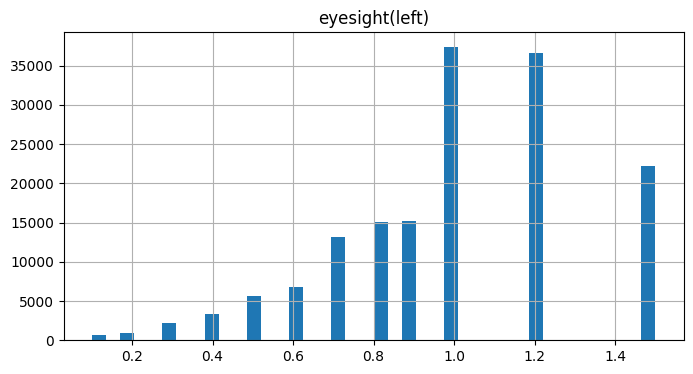

In [23]:
data[['eyesight(left)']].hist(bins=40,figsize=(8,4))
plt.show()

### Hearing (Right)
We **could not determine** whether there are any outliers in "hearing", because the ones on the right make up a considerable amount.

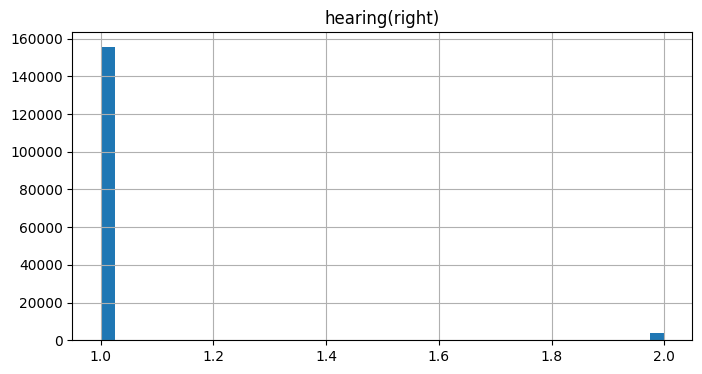

Value Counts:
1    155526
2      3730
Name: hearing(right), dtype: int64

Percentage of each value:
1    97.657859
2     2.342141
Name: hearing(right), dtype: float64


In [24]:
data[['hearing(right)']].hist(bins=40,figsize=(8,4))
plt.show()

value_counts = data['hearing(right)'].value_counts()
total_count = len(data['hearing(right)'])
percentages = (value_counts / total_count) * 100

print("Value Counts:")
print(value_counts)
print("\nPercentage of each value:")
print(percentages)

**2.34%** of the sample data have **hearing values = 2**, so we decided not to consider them as outliers.

Assuming that when Hearing Value is:
> 1 -> Normal Hearing

> 2 -> Hearing disability

## 2) Transformations

### ALT Transformation
>ALT feature was highly skewed to the right, so we applied LOG Transformation on it to reduce the skewness.

 > **Skeweness:** In the context of data analysis, skewness refers to the distortion or asymmetry in a symmetrical bell curve, or normal distribution, in a set of data. Skewness can affect statistical analyses and the performance of machine learning models.

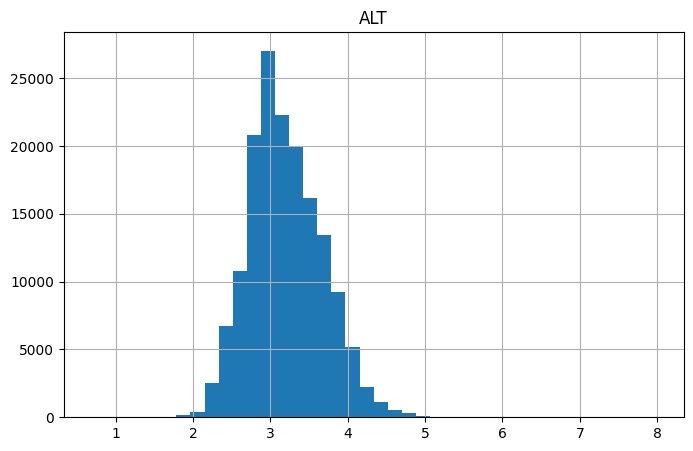

In [25]:
data['ALT'] = np.log(data['ALT'] + 1)  # Adding 1 to avoid log(0)
data[['ALT']].hist(bins=40,figsize=(8,5))
plt.show()

### HDL Transformation
> HDL feature was also skewed to the right, so we applied LOG Transformation on it to reduce the skewness.

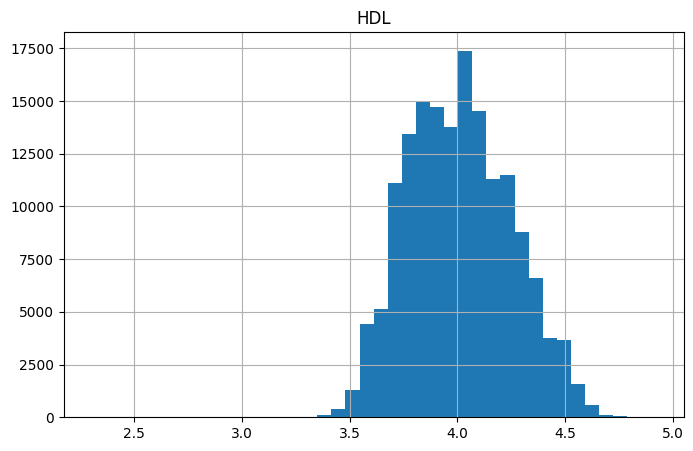

In [26]:
data['HDL'] = np.log(data['HDL'] + 1)  # Adding 1 to avoid log(0)
data[['HDL']].hist(bins=40,figsize=(8,5))
plt.show()

In [27]:
# These are the plots after applying transformations on our features
# data[['ALT','eyesight(left)','hemoglobin'	,'age','waist(cm)','hearing(right)','height(cm)','systolic','HDL']].hist(bins=40,figsize=(20,15))
# plt.show()

## 3) Creating New Features

### PRF (Physiological Risk Factor)
-------------------------------------------------------------------------------
#### **Biological Explanation:**

**1. ALT (Alanine Aminotransferase):**

This is a liver enzyme that, when elevated, can indicate liver inflammation or damage. Smoking can lead to oxidative stress, which may damage liver cells and result in elevated ALT levels.

**2. Hemoglobin:**

Hemoglobin is the protein in red blood cells that carries oxygen throughout the body. Smokers often have higher levels of carboxyhemoglobin, a hemoglobin bound to carbon monoxide (CO) instead of oxygen (O2). This can lead to a compensatory increase in hemoglobin levels to maintain adequate oxygenation.

**3. Systolic Blood Pressure:**

This is the pressure in the arteries when the heart beats. Smoking can cause an immediate, temporary increase in blood pressure and long-term smoking can lead to sustained hypertension.

**4. HDL (High-Density Lipoprotein):**

Known as "good" cholesterol, HDL helps remove other forms of cholesterol from the bloodstream. Smoking can lower HDL cholesterol, contributing to the buildup of plaques in arteries (atherosclerosis).

***Smoking Leads to high ALT, high Hemoglobin, high Systolic Blood Pressure, and low HDL.***

-------------------------------------------------------------------------------
#### **Mathematical Explanation:**

#### **PRF = Z(ALT) + Z(hemoglobin) + Z(systolic) - Z(HDL)**

The PRF aims to combine these factors into a single, standardized score that could be more correlated with smoking than any individual feature.

> If the PRF is high, it suggests a profile of elevated ALT, hemoglobin, and blood pressure, along with lower HDL, which could be associated with smoking.

> If the PRF is low, it suggests a healthier physiological profile with respect to these particular metrics.

In [28]:
# ANOTHER NEW FEATURE "PRF"
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['systolic', 'HDL', 'hemoglobin', 'age', 'waist(cm)', 'eyesight(left)', 'ALT']])
df_scaled = pd.DataFrame(scaled_features, columns=['systolic', 'HDL', 'hemoglobin', 'age', 'waist(cm)', 'eyesight(left)', 'ALT'])

# Create the new features
data['PRF'] = df_scaled['ALT'] + df_scaled['hemoglobin'] + df_scaled['systolic'] - df_scaled['HDL']

# Calculate correlations
corr_prf = data['PRF'].corr(data['smoking'])
print(f"Correlation of Physiological Risk Factor (PRF) with smoking: {corr_prf}")
data.head()

Correlation of Physiological Risk Factor (PRF) with smoking: 0.38040431315981543


,ALT,eyesight(left),hemoglobin,age,waist(cm),hearing(right),height(cm),systolic,HDL,smoking,PRF
0,3.258097,0.5,16.5,55,81.0,1,165,135,3.713572,1,3.556409
1,3.178054,0.6,16.2,70,89.0,2,165,146,4.060443,0,2.586802
2,3.465736,0.4,17.4,20,81.0,1,170,118,3.828641,1,2.803413
3,3.332205,1.5,15.9,35,105.0,1,180,131,3.663562,0,3.188675
4,2.639057,1.5,15.4,30,80.5,1,165,121,3.806662,1,-0.004404


# After Feature Engineering

## Heatmap

<Axes: >

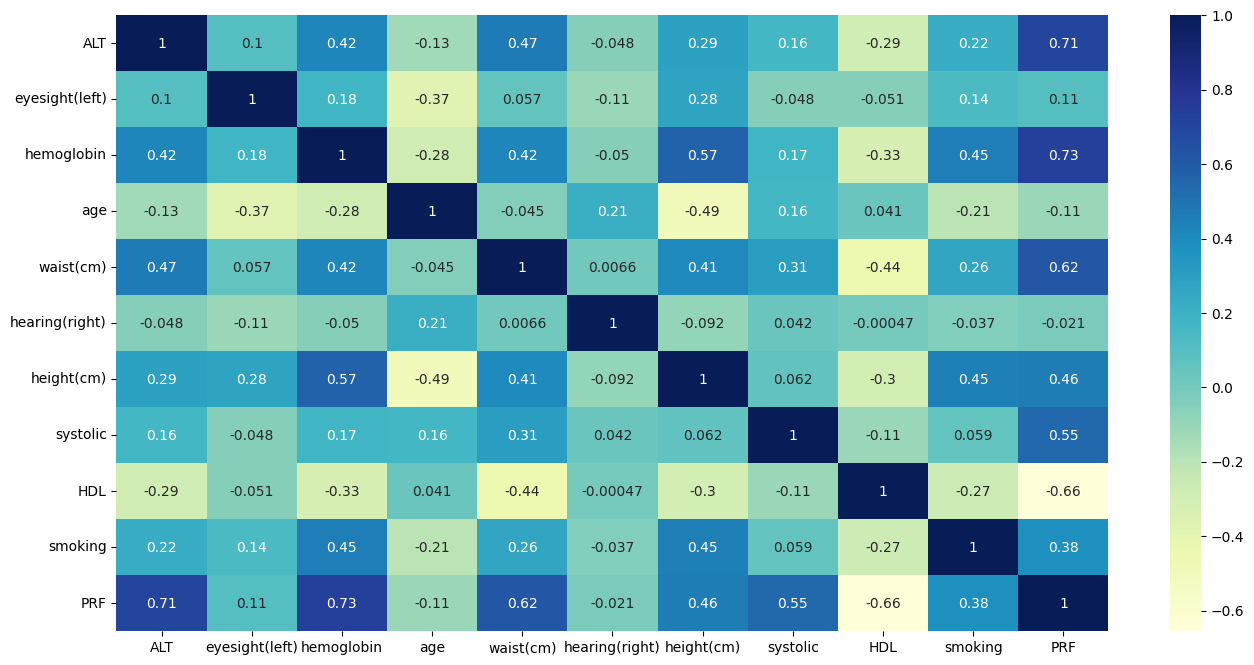

In [29]:
data.corr()
corr_matrix=data.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

## Correlation Sorting

In [30]:
corr_matrix["smoking"].sort_values(ascending=False)

smoking           1.000000
hemoglobin        0.450679
height(cm)        0.447111
PRF               0.380404
waist(cm)         0.262715
ALT               0.221133
eyesight(left)    0.135343
systolic          0.058642
hearing(right)   -0.036858
age              -0.206033
HDL              -0.273587
Name: smoking, dtype: float64

# Pre - Training Steps

## 1) Dropping Undesired Columns

We drop the 'id' field since it is a non-predictive auto-incremented field, and also the target 'smoking' into the vector y.



In [35]:
X = data.drop(['smoking'], axis=1)  # Features
y = data['smoking']  # Target variable
X.head()

,ALT,eyesight(left),hemoglobin,age,waist(cm),hearing(right),height(cm),systolic,HDL,PRF
0,3.258097,0.5,16.5,55,81.0,1,165,135,3.713572,3.556409
1,3.178054,0.6,16.2,70,89.0,2,165,146,4.060443,2.586802
2,3.465736,0.4,17.4,20,81.0,1,170,118,3.828641,2.803413
3,3.332205,1.5,15.9,35,105.0,1,180,131,3.663562,3.188675
4,2.639057,1.5,15.4,30,80.5,1,165,121,3.806662,-0.004404


## 2) Splitting the dataset
We randomly split our dataset into 70% Training + 15% Testing + 15% Validation

In [36]:
# First split 100% -> 70% Train + 30% Temp
X_train, X_temp, y_train, y_temp = train_test_split(X , y , test_size = 0.3 , random_state = 42)

# Second split 30% -> 15% Test + 15% Validate
X_test, X_valid, y_test, y_valid = train_test_split(X_temp , y_temp , test_size = 0.5 , random_state = 42)

In [37]:
# Some Prints to validate correct splitting
print("Training set shape X:", X_train.shape, "and y:", y_train.size)
print("Validation set shape X:", X_valid.shape, "and y:", y_valid.size)
print("Test set shape X:", X_test.shape, "and y:", y_test.size)

Training set shape X: (111479, 10) and y: 111479
Validation set shape X: (23889, 10) and y: 23889
Test set shape X: (23888, 10) and y: 23888


# Normalization

In [40]:
# Define the features
features_to_minmax = ['ALT', 'eyesight(left)', 'hemoglobin', 'age', 'waist(cm)', 'hearing(right)']
features_to_standardize = ['height(cm)', 'systolic', 'HDL']

df = pd.DataFrame(data)

# Create two subsets of features
subset_minmax = df[features_to_minmax]
subset_standardize = df[features_to_standardize]

# Apply Min-Max scaling to the first subset
scaler_minmax = MinMaxScaler()
subset_minmax_scaled = scaler_minmax.fit_transform(subset_minmax)
df_minmax = pd.DataFrame(subset_minmax_scaled, columns=features_to_minmax)

# Apply Z-score normalization to the second subset
scaler_standardize = StandardScaler()
subset_standardize_scaled = scaler_standardize.fit_transform(subset_standardize)
df_standardize = pd.DataFrame(subset_standardize_scaled, columns=features_to_standardize)

# Combine the two subsets back into the original dataframe
df_normalized = pd.concat([df_minmax, df_standardize, df['smoking']], axis=1)

# Display the first few rows of the normalized DataFrame
print(df_normalized.head())

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df_normalized.drop('smoking', axis=1), df_normalized['smoking'], test_size=0.30, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Assemble 'X_train' and 'y_train' into a single DataFrame without resetting index
df_train = pd.concat([X_train, y_train], axis=1)

# Assemble 'X_validate' and 'y_validate' into a single DataFrame without resetting index
df_validate = pd.concat([X_validate, y_validate], axis=1)

# Assemble 'X_test' and 'y_test' into a single DataFrame without resetting index
df_test = pd.concat([X_test, y_test], axis=1)

######
# Assemble 'X_train' and 'y_train' into a single DataFrame
#df_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train.reset_index(drop=True), columns=['smoking'])], axis=1)

# Assemble 'X_validate' and 'y_validate' into a single DataFrame
#df_validate = pd.concat([pd.DataFrame(X_validate), pd.DataFrame(y_validate.reset_index(drop=True), columns=['smoking'])], axis=1)

# Assemble 'X_test' and 'y_test' into a single DataFrame
#df_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test.reset_index(drop=True), columns=['smoking'])], axis=1)
######

# Display the first few rows of each new DataFrame
print("Training Data:")
print(df_train.head())

print("\nValidation Data:")
print(df_validate.head())

print("\nTest Data:")
print(df_test.head())


        ALT  eyesight(left)  hemoglobin       age  waist(cm)  hearing(right)  \
0  0.352112        0.285714    0.720497  0.538462   0.394737             0.0   
1  0.341124        0.357143    0.701863  0.769231   0.500000             1.0   
2  0.380616        0.214286    0.776398  0.000000   0.394737             0.0   
3  0.362285        1.000000    0.683230  0.230769   0.710526             0.0   
4  0.267131        1.000000    0.652174  0.153846   0.388158             0.0   

   height(cm)  systolic       HDL  smoking  
0   -0.030268  0.981702 -1.251174        1  
1   -0.030268  1.845852  0.204657        0  
2    0.536694 -0.353802 -0.768224        1  
3    1.670617  0.667465 -1.461070        0  
4   -0.030268 -0.118125 -0.860470        1  
Training Data:
            ALT  eyesight(left)  hemoglobin       age  waist(cm)  \
17406  0.400546        0.642857    0.608696  0.384615   0.423684   
61303  0.352112        0.642857    0.608696  0.461538   0.328947   
71781  0.276602        0.57142

In [41]:
df_train.head()

,ALT,eyesight(left),hemoglobin,age,waist(cm),hearing(right),height(cm),systolic,HDL,smoking
17406,0.400546,0.642857,0.608696,0.384615,0.423684,0.0,-0.030268,1.060261,-1.150036,1
61303,0.352112,0.642857,0.608696,0.461538,0.328947,0.0,-0.597229,-0.432361,1.448097,1
71781,0.276602,0.571429,0.521739,0.307692,0.171053,0.0,-0.597229,-2.239220,0.551718,1
67014,0.362285,0.571429,0.496894,0.615385,0.328947,0.0,-1.164191,-1.767866,0.484563,0
73322,0.285462,0.428571,0.565217,0.615385,0.315789,1.0,-1.164191,1.060261,-0.677961,0


In [42]:
df_train.to_csv('/content/drive/MyDrive/train_set.csv', index=False)
df_validate.to_csv('/content/drive/MyDrive/validation_set.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/test_set.csv', index=False)